In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# setup: has to be in a separate cell for some reason
plt.rcParams['figure.figsize'] = [8, 8]

In [3]:
# from last time
def slim_script(script, name, quiet=False):
    logfile = name + ".log"
    out = os.system("echo '" + script + "' | slim > " + logfile + " 2>&1")
    if not quiet:
        with open(logfile, "r") as log:
            print(log.read())
    if out != 0:
        print("An error occurred.")
    return out, logfile

# Adding geography

In reality, all individual interactions are *local*, to some degree.
This can have important effects on the population dynamics in a lot of ways
(sometimes hard to predict), for instance:

- *sources and sinks*: some places are better than others
- *local inbreeding*: spatial mate choice can reduce diversity
- *buffering*: local bad years ameliorated by immigration from elsewhere

We'll start on this by implementing a spatial logistic population model.

# Spatial logistic model

We'll start with a model on a single type/species,
in which the population doesn't blow up because the fecundity goes down with population size:

1. Everyone has a Poisson($\lambda / (1 + N/K)$) number of babies<br>
    a. with a randomly chosen mate.
2. Everyone dies with probability $\mu$.

This should equilibrate around where the birth and death rates are equal
(actually, where birth-plus-surviving-to-adulthood and adult-death rates are equal),
at $N_* = K(\lambda(1-\mu)/\mu - 1)$.

In [4]:
logistic_fecundity_recipe = """
initialize() {
    initializeSLiMModelType("nonWF");
    initializeMutationRate(1e-7);
    initializeMutationType("m1", 0.5, "f", 0.0);
    initializeGenomicElementType("g1", m1, 1.0);
    initializeGenomicElement(g1, 0, 99999);
    initializeRecombinationRate(1e-8);    

    defineConstant("LAMBDA", 2.0); // birth rate
    defineConstant("K", 100);      // carrying capacity
    defineConstant("MU", 0.5);      // death rate
}

// the reproduction callback only applies to p2 (adults)
reproduction() {
    num_offspring = rpois(1, LAMBDA / (1 + p1.individualCount / K));
    for (k in seqLen(num_offspring)) {
        p1.addCrossed(individual, subpop.sampleIndividuals(1));
    }
}

1 early() {
    // initial population
    sim.addSubpop("p1", K);
}


early() {
    // survival probabilities
    p1.fitnessScaling = 1 - MU;
}

1: early() {
    cat(sim.generation + " : population size, early :" + p1.individualCount);
}

1: late() {
    catn( " : late :" + p1.individualCount);
}

100 {
    sim.simulationFinished();
}
"""
out, logfile = slim_script(logistic_fecundity_recipe, "logistic_fecundity_recipe")


// Initial random seed:
1860026357959

// RunInitializeCallbacks():
initializeSLiMModelType(modelType = 'nonWF');
initializeMutationRate(1e-07);
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 99999);
initializeRecombinationRate(1e-08);

// Starting run at generation <start>:
1 

1 : population size, early :100 : late :50
2 : population size, early :102 : late :59
3 : population size, early :126 : late :67
4 : population size, early :143 : late :75
5 : population size, early :132 : late :63
6 : population size, early :149 : late :69
7 : population size, early :145 : late :69
8 : population size, early :150 : late :80
9 : population size, early :188 : late :78
10 : population size, early :163 : late :79
11 : population size, early :178 : late :89
12 : population size, early :194 : late :88
13 : population size, early :194 : late :99
14 : population size, early :200 : late :96
15 : population size, early :218 : late :127
16 

## Interactions

Making a SLiM simulation "spatial" involves two steps:
1. Setting the *dimensionality* of space (either 'x', 'xy', or 'xyz'),
    with e.g., `initializeSLiMOptions(dimensionality='xy')`,
    giving individuals (and their offspring) spatial locations, and
2. Setting up *interactions* to mediate everything you want to be spatial.

### Spatial position

Telling SLiM it will be a spatial simulation with `dimensionality='xy'`
option makes it so that all invdividuals have new attributes, `.x` and `.y`, and also `spatialPosition` (which is `(x,y)`). 
The first things to do are to (1) initialize spatial positions:
```
1 early() {
    sim.addSubpop("p1", K);
    sim.setSpatialBounds(c(0, 0, 100, 100));
    for (ind in p1.individuals) {
        ind.spatialPosition = p1.pointUniform();
    }
}
```
and (2) make them heritable:
```
reproduction() {
    num_offspring = rpois(1, LAMBDA / (1 + p1.individualCount / K));
    for (k in seqLen(num_offspring)) {
        offspring = p1.addCrossed(individual, subpop.sampleIndividuals(1));
        pos = individual.spatialPosition + rnorm(2, 0, SIGMA);
        offspring.setSpatialPosition(p1.pointReflected(pos));
    }
}
```

### Spatial interactions

*Interactions* are how SLiM handles all the overhead of looking up
"who is close to who", more or less.
More concretely, an *interaction* lets you find out,
for each individual, the *distance* and *interaction strength*
to every other individual within some *maximum interaction distance*.
"Interaction strength" is just putting the distance through a function
(that gets smaller with bigger distances);
a usual choice is the Normal density ("n").
We will use one to make the number of nearby individuals
decrease fecundity.

First, we have to initialize it:
```
    // spatial interaction for local competition
    initializeInteractionType("i1", "xy", reciprocal=T,
                maxDistance=3 * SIGMA);
    i1.setInteractionFunction("n", 1.0/(2*PI*SIGMA^2), SIGMA);
```
(The choice of $1/(2 \pi \sigma^2)$ for the max strength
makes the sum of all interactions have units of
individuals per unit area.)

Then, in `reproduction()`, we use it:
```
reproduction() {
    num_neighbors = i1.totalOfNeighborStrengths(individual);
    num_offspring = rpois(1, LAMBDA / (1 + num_neighbors / K));
```

In [5]:
spatial_logistic_fecundity_recipe = """
initialize() {
    initializeSLiMModelType("nonWF");
    initializeSLiMOptions(dimensionality="xy");
    initializeMutationRate(1e-7);
    initializeMutationType("m1", 0.5, "f", 0.0);
    initializeGenomicElementType("g1", m1, 1.0);
    initializeGenomicElement(g1, 0, 99999);
    initializeRecombinationRate(1e-8);    

    defineConstant("LAMBDA", 2.0); // birth rate
    defineConstant("K", 1);      // carrying capacity per unit area
    defineConstant("MU", 0.5);     // death rate
    defineConstant("SIGMA", 0.5);  // interaction distance

    // output locations to here
    defineConstant("OUTFILE", "logistic_locs.txt");
    writeFile(OUTFILE, "time x y");
    
    // spatial interaction for local competition
    initializeInteractionType("i1", "xy", reciprocal=T,
                maxDistance = 3 * SIGMA);
    i1.setInteractionFunction("n", 1.0/(2*PI*SIGMA^2), SIGMA);
}

reproduction() {
    neighbor_density = i1.totalOfNeighborStrengths(individual);
    num_offspring = rpois(1, LAMBDA / (1 + neighbor_density / K));
    mate = i1.drawByStrength(individual, 1);  // single mating
    if (size(mate) > 0) {
        for (k in seqLen(num_offspring)) {
            offspring = p1.addCrossed(individual, mate);
            pos = individual.spatialPosition + rnorm(2, 0, SIGMA);
            offspring.setSpatialPosition(p1.pointReflected(pos));
        }
    }
}

1 early() {
    sim.addSubpop("p1", K * 10 * 10);
    p1.setSpatialBounds(c(0.0, 0.0, 10.0, 10.0));
    for (ind in p1.individuals) {
        ind.setSpatialPosition(p1.pointUniform());
    }
}

early() {
    // survival probabilities
    p1.fitnessScaling = 1 - MU;
}

1: early() {
    cat(sim.generation + " : population size, early :" + p1.individualCount);
}

1: late() {
    catn( " : late :" + p1.individualCount);
    for (ind in p1.individuals) {
        writeFile(OUTFILE, sim.generation + " " + ind.x + " " + ind.y, append=T);
    }
}

late() {
    i1.evaluate();
}

100 {
    sim.simulationFinished();
}
"""
out, logfile = slim_script(spatial_logistic_fecundity_recipe, "spatial_logistic_fecundity_recipe")


// Initial random seed:
1860056358001

// RunInitializeCallbacks():
initializeSLiMModelType(modelType = 'nonWF');
initializeSLiMOptions(dimensionality = 'xy');
initializeMutationRate(1e-07);
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 99999);
initializeRecombinationRate(1e-08);
initializeInteractionType(1, "xy", reciprocal=T, maxDistance=1.5);

// Starting run at generation <start>:
1 

1 : population size, early :100 : late :58
2 : population size, early :121 : late :60
3 : population size, early :118 : late :68
4 : population size, early :124 : late :66
5 : population size, early :137 : late :79
6 : population size, early :158 : late :73
7 : population size, early :140 : late :83
8 : population size, early :165 : late :78
9 : population size, early :166 : late :95
10 : population size, early :172 : late :91
11 : population size, early :187 : late :98
12 : population size, early :208 : late :101
13 : population size, 

*Homework:*

1. let survival rate go *up* (or, change somehow) with number of neighbors
2. choose mates from nearby
3. make sure no offspring are within some small distance of anyone else


### Plotting spatial locations in python

Since we wrote out the spatial locations, we can plot them.
Here's a scatterplot of the initial locations.

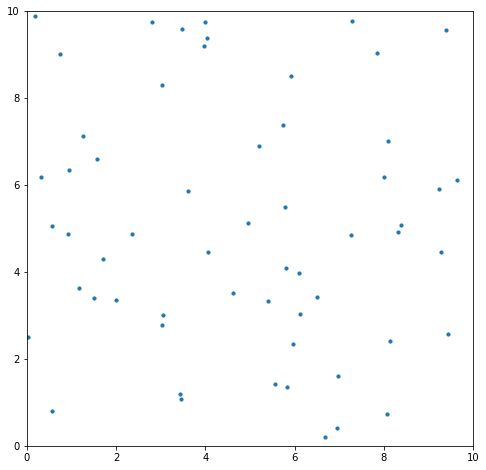

In [6]:
txy = np.loadtxt("logistic_locs.txt", skiprows=1)
xy = txy[:,1:3]
t = txy[:,0]

fig, ax = plt.subplots()
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
points = ax.scatter(xy[t == 1, 0], xy[t == 1, 1], s=10);

With some additional magic, we can make a *movie* of the locations, through time!
Careful, this can take a long time if the simulation gets big.

In [7]:
import matplotlib.animation as ani
from IPython.display import HTML

def update(frame):
    points.set_offsets(xy[t == frame, :])
    return points

animation = ani.FuncAnimation(fig, update,
                              frames=np.linspace(1, 100, 100))
HTML(animation.to_html5_video())

# Predator-prey model

SLiM has no problem modeling multispecies interactions.
However, it's not *designed* for that, so the way we do it is a *little* roundabout
(like, it has no "A eats B" function)
... and both species have to have exactly the same genome arrangement.
(We could have their fitnesses be affected by completely different sets of mutations, though.)

## The plan

With $N$ and $M$ the numbers of prey and predators, respectively:

0. Prey have an average of $B/(1 + N/K)$ offspring.
1. Each prey encounters a Binomial$(M, a)$ number of predators, randomly chosen, per time step.
2. Each encounter leads to the prey being eaten with probability $c$.
3. When the prey is eaten, we record that fact by setting its `fitnessScaling` to 0.
4. Prey provide the predator with $\epsilon$ units of energy,
    which we store in their `tagF` property. (Note: prey can't be eaten twice.)
5. Predators have a Poisson number of offspring, with mean equal to their current amount of energy,
    which is then set to zero.
6. Predators then each die, with probability $\delta$ each.
7. Prey also die, with probability $d$.



**Exercise:** What is the equilibrium of this system?

In [8]:
pp_recipe = """
initialize() {
    initializeSLiMModelType("nonWF");
    initializeSLiMOptions(dimensionality="xy");
    initializeMutationRate(0.0);
    initializeMutationType("m1", 0.5, "f", 0.0);
    initializeGenomicElementType("g1", m1, 1.0);
    initializeGenomicElement(g1, 0, 1);
    initializeRecombinationRate(0.0);    

    defineConstant("B", 2); // prey birth rate
    defineConstant("K", 100); // prey carrying capacity
    defineConstant("C", 0.5);    // predation prob
    defineConstant("EPSILON", 0.2); // conversion rate
    defineConstant("DELTA", 0.2);  // predator death prob
    defineConstant("D", 0.01);    // prey death prob
    defineConstant("W", 3);    // prey death prob
    defineConstant("SIGMA", 0.1);    // spatial interaction and dispersal
    
    // output numbers to here
    defineConstant("OUTFILE", "pp_nums.txt");
    writeFile(OUTFILE, "prey predators");
    defineConstant("PREYFILE", "pp_prey.txt");
    writeFile(PREYFILE, "t x y");    
    defineConstant("PREDFILE", "pp_pred.txt");
    writeFile(PREDFILE, "t x y");
    catn("Writing out prey, predator numbers to " + OUTFILE + " and " + PREDFILE + " and " + PREYFILE);
        
    // spatial interaction for local competition
    initializeInteractionType("i1", "xy", reciprocal=T,
                maxDistance = 3 * SIGMA);
    i1.setInteractionFunction("n", 1.0/(2*PI*SIGMA^2), SIGMA);
}

// prey
reproduction(p1) {
    num_offspring = rpois(1, B / (1 + p1.individualCount/K));
    for (k in seqLen(num_offspring)) {
        offspring = p1.addCrossed(individual, p1.sampleIndividuals(1));
        pos = individual.spatialPosition + rnorm(2, 0.0, SIGMA);
        offspring.setSpatialPosition(p1.pointReflected(pos));
    }
}

// predators
reproduction(p2) {
    if (individual.tagF > 0) {
        num_offspring = rpois(1, individual.tagF);
        for (k in seqLen(num_offspring)) {
            offspring = p2.addCrossed(individual, p2.sampleIndividuals(1));
            offspring.tagF = 0.0; // need to initialize these
            pos = individual.spatialPosition + rnorm(2, 0.0, SIGMA);
            offspring.setSpatialPosition(p2.pointReflected(pos));
        }
    }
}

1 early() {
    // initial population
    sim.addSubpop("p1", asInteger(K * W * W));
    p1.setSpatialBounds(c(0.0, 0, W, W));
    sim.addSubpop("p2", asInteger(K * W * W));
    p2.setSpatialBounds(c(0.0, 0, W, W));
    for (ind in c(p1.individuals, p2.individuals)) {
        ind.setSpatialPosition(p1.pointUniform());
    }
}

early() {
    // survival probabilities
    p1.fitnessScaling = 1-D;
    p2.fitnessScaling = 1-DELTA;
}

early() {
    i1.evaluate();
    // num_predators = p2.individualCount;
    // fatal_encounters = rbinom(p1.individualCount, num_predators, A * C);
    for (prey in p1.individuals) {
        predators = i1.nearestNeighborsOfPoint(p2, prey.spatialPosition); // this is everyone with 3 sigma
        num_fatal_encounters = rbinom(1, size(predators), C);
        if (num_fatal_encounters > 0) {
            predator = sample(predators, 1);
            predator.tagF = predator.tagF + EPSILON;
            prey.fitnessScaling = 0.0;
        }
    }
}

1: early() {
    writeFile(OUTFILE, p1.individualCount + " " + p2.individualCount, append=T);
    if (sim.generation < 100) {
        cat(sim.generation + " : prey : " + p1.individualCount);
        catn(" : predators : " + p2.individualCount);
    }
    for (ind in p1.individuals) 
        writeFile(PREYFILE, sim.generation + " " + ind.x + " " + ind.y, append=T);
    for (ind in p2.individuals) 
        writeFile(PREDFILE, sim.generation + " " + ind.x + " " + ind.y, append=T);
}

100 {
    sim.simulationFinished();
}
"""
out, logfile = slim_script(pp_recipe, "pp_recipe")

// Initial random seed:
1860276361098

// RunInitializeCallbacks():
initializeSLiMModelType(modelType = 'nonWF');
initializeSLiMOptions(dimensionality = 'xy');
initializeMutationRate(0);
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 1);
initializeRecombinationRate(0);
Writing out prey, predator numbers to pp_nums.txt and pp_pred.txt and pp_prey.txt
initializeInteractionType(1, "xy", reciprocal=T, maxDistance=0.3);

// Starting run at generation <start>:
1 

1 : prey : 900 : predators : 900
2 : prey : 621 : predators : 822
3 : prey : 462 : predators : 741
4 : prey : 376 : predators : 739
5 : prey : 314 : predators : 733
6 : prey : 285 : predators : 740
7 : prey : 270 : predators : 703
8 : prey : 245 : predators : 695
9 : prey : 209 : predators : 645
10 : prey : 214 : predators : 617
11 : prey : 231 : predators : 585
12 : prey : 200 : predators : 574
13 : prey : 205 : predators : 537
14 : prey : 239 : predators : 510
15 : 

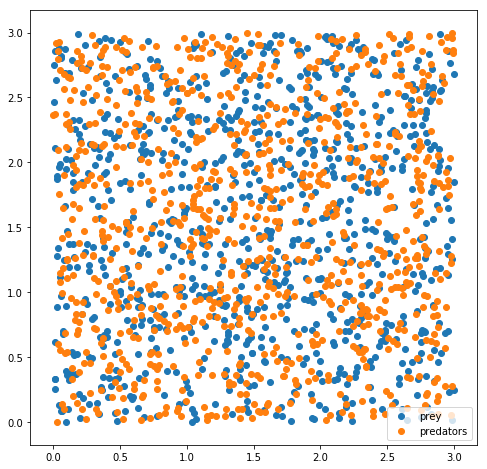

In [11]:
prey = np.loadtxt("pp_prey.txt", skiprows=1)
prey_t = prey[:, 0]
prey_xy = prey[:, 1:3]
pred = np.loadtxt("pp_pred.txt", skiprows=1)
pred_t = pred[:, 0]
pred_xy = pred[:, 1:3]

fig, ax = plt.subplots()
prey_points = ax.scatter(prey_xy[prey_t == 1, 0], prey_xy[prey_t == 1, 1], label='prey')
pred_points = ax.scatter(pred_xy[pred_t == 1, 0], pred_xy[pred_t == 1, 1], label='predators')
ax.legend();

In [12]:
import matplotlib.animation as ani
from IPython.display import HTML

def update(frame):
    prey_points.set_offsets(prey_xy[prey_t == frame, :])
    pred_points.set_offsets(pred_xy[pred_t == frame, :])
    return points

animation = ani.FuncAnimation(fig, update,
                              frames=np.linspace(1, 100, 100))
HTML(animation.to_html5_video())